# Ridge regression
This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
minimize two elements, the RSS and the objective function 

In ridge regression two elements are optimized , the RSS and the objective function

$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $

It is a variation of the Linear regression with a tunning parameter alpha to control model complexity.
need to do a trade off between variance and bias
1. the inhability for the model to capture the true relationship is called bias. How well the model fits our data 
2. how well model does on a completely new dataset. 

use the hyper parameter called alpha , to add a bias , prevent the model from real, it will have better accurancy on the testing set, it means it will not overfit in the training set.  

## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression. First, let's download the libraries 

In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split

#from LinearRegression.RidgeRegression.cholesky import Cholesky

## Dataset analysis

Open the database, check the structure, show the head, take a look of its structure, the descriptive statistics and manage the columns.

Create the constants

The target value is the median_house_value which is predicted based on the features of different houses.

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

In [2]:
RMS = 'neg_mean_squared_error'

In [3]:
standardize = False

fit_intercept = True
normalize = True

shuffleDataSet = True

Valori di ɑ usati

In [4]:
alphas = numpy.linspace(1e-5, 2.0, 30)

In [5]:
print(alphas)

[1.00000000e-05 6.89751724e-02 1.37940345e-01 2.06905517e-01
 2.75870690e-01 3.44835862e-01 4.13801034e-01 4.82766207e-01
 5.51731379e-01 6.20696552e-01 6.89661724e-01 7.58626897e-01
 8.27592069e-01 8.96557241e-01 9.65522414e-01 1.03448759e+00
 1.10345276e+00 1.17241793e+00 1.24138310e+00 1.31034828e+00
 1.37931345e+00 1.44827862e+00 1.51724379e+00 1.58620897e+00
 1.65517414e+00 1.72413931e+00 1.79310448e+00 1.86206966e+00
 1.93103483e+00 2.00000000e+00]


Create the constants

In [6]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [7]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

if shuffleDataSet:
    data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [8]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [9]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.39,37.73,46.0,1517.0,299.0,879.0,309.0,2.2222,195100.0,NEAR BAY
1,-118.47,33.99,52.0,1523.0,447.0,636.0,408.0,3.0682,412500.0,<1H OCEAN
2,-121.98,37.95,14.0,6290.0,854.0,2724.0,820.0,6.7371,267400.0,INLAND
3,-122.21,37.80,39.0,2003.0,500.0,1109.0,464.0,3.0682,156500.0,NEAR BAY
4,-118.11,33.84,36.0,1756.0,297.0,798.0,287.0,5.5581,218300.0,<1H OCEAN


Here is the distribution of the values of the target variable "median_house_value".
It looks like a normal distribution with a group of outliers on the highest value of the house.

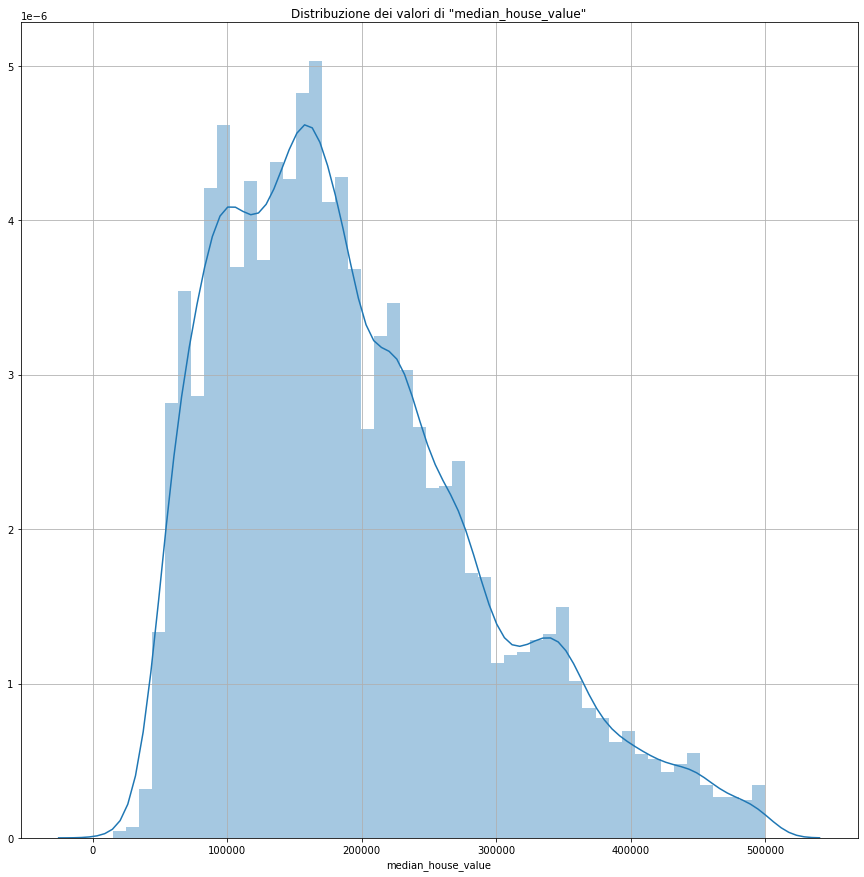

In [11]:
outliers = data_frame[data_frame[column_to_predict] == 500001].index
data_frame.drop(outliers , inplace=True)

plt.figure(figsize=(15, 15))
plt.title('Distribuzione dei valori di "median_house_value"')
seaborn.distplot(data_frame[column_to_predict])
plt.grid()
plt.show()

## Data pre-processing 
###  Missing values

The dataset contains missing values which are handeled by replacing the value with the mean value of the column. This procedure is necessary to avoid errors in the execution.

In [12]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)


### Categorical feature
Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers.
We generate columns for each element of the categorical feature. 

In [13]:
columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

columns_categories


,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,0,0,0,1,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,1,0,0,0,0
...,...,...,...,...,...
20635,1,0,0,0,0
20636,0,1,0,0,0
20637,0,1,0,0,0
20638,0,1,0,0,0


Then delete the categorical column and add a column for each element of the deleted categorical column

In [14]:
data_frame.drop(columns=categories_columns, inplace=True)
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 

Equazioni esempio:
$$ \hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j}  $$

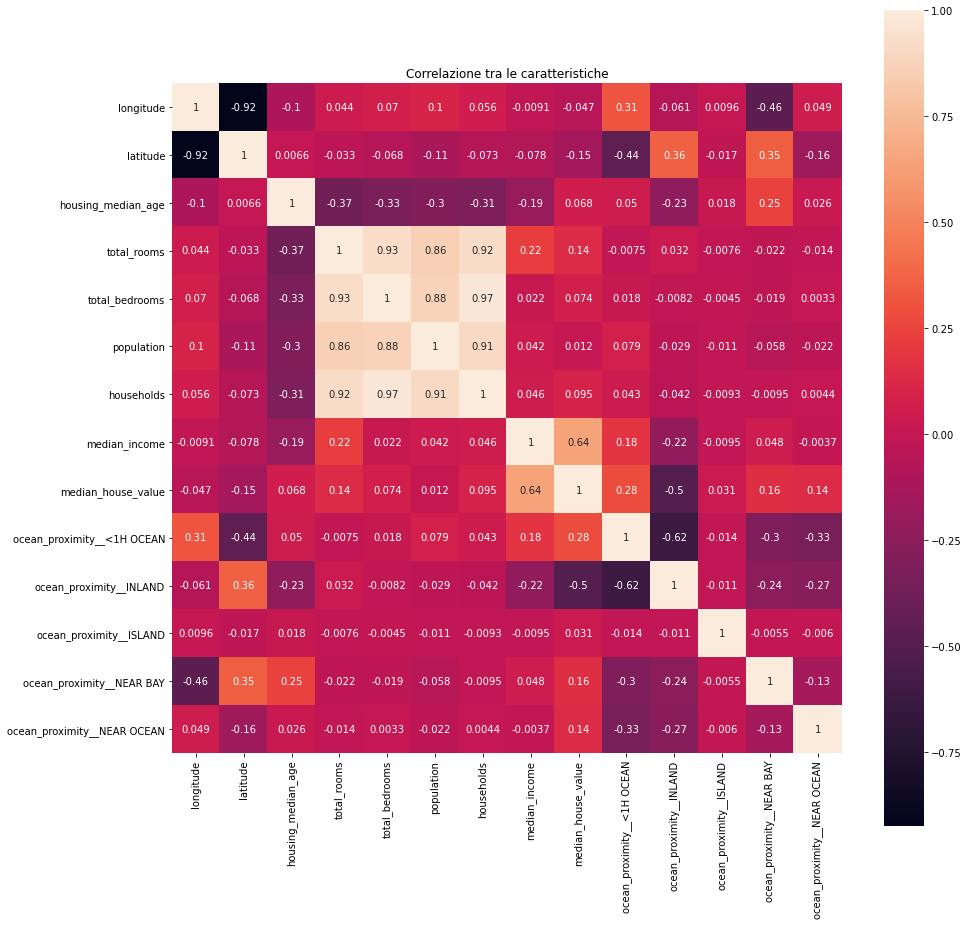

In [15]:
corr = data_frame.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlazione tra le caratteristiche')
seaborn.heatmap(corr, square=True, annot=True)
plt.show()

Pearson's coefficient is determined by :

$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [16]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.930916,0.859590,0.921102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.930916,NaN,0.875270,0.974006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.859590,0.875270,NaN,0.908997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.921102,0.974006,0.908997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see the pairs of the most correlated features are 
(households - total_bedrooms)
(population - housegìholds)
(total_rooms - total_bedrooms)
(total_bedroom - households)

Delete the correlated features

1. population 
2. total_rooms

In [17]:
columns_to_remove = ['latitude', 'population', 'total_rooms', column_to_predict]
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

X = data_frame.drop(columns=columns_to_remove)
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [18]:
X

,longitude,housing_median_age,total_bedrooms,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.39,46.0,299.0,309.0,2.2222,0,0,0,1,0
1,-118.47,52.0,447.0,408.0,3.0682,1,0,0,0,0
2,-121.98,14.0,854.0,820.0,6.7371,0,1,0,0,0
3,-122.21,39.0,500.0,464.0,3.0682,0,0,0,1,0
4,-118.11,36.0,297.0,287.0,5.5581,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
20635,-117.21,21.0,612.0,593.0,4.8152,1,0,0,0,0
20636,-120.95,11.0,814.0,686.0,3.7041,0,1,0,0,0
20637,-117.27,36.0,676.0,585.0,4.1000,0,1,0,0,0
20638,-117.46,3.0,2315.0,1759.0,4.2429,0,1,0,0,0


Quindi la nostra attuale y è la seguente:

In [19]:
y

0        195100.0
1        412500.0
2        267400.0
3        156500.0
4        218300.0
           ...   
20635    218500.0
20636    174800.0
20637     96400.0
20638    147300.0
20639     81600.0
Name: median_house_value, Length: 19675, dtype: float64

### Evaluate a score by cross-validation

We start by investigating the sensitivity of the CV risk estimate to the choice of α.

In [20]:
cholesky = Ridge(alpha=1e-15, solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)
scores__c = cross_val_score(cholesky, X, y, cv=5, scoring=RMS)
cvrs__c = numpy.round(-scores__c.mean(), decimals=2)
print(f'The cross-validated risk estimate with Cholesky is: {cvrs__c}')


svd = Ridge(alpha=1e-15, solver='svd', fit_intercept=fit_intercept, normalize=normalize)
scores__s = cross_val_score(svd, X, y, cv=5, scoring=RMS)
cvrs__s = numpy.round(-scores__s.mean(), decimals=2)
print(f'The cross-validated risk estimate with SVD is: {cvrs__s}')

The cross-validated risk estimate with Cholesky is: 4079513855.35
The cross-validated risk estimate with SVD is: 4079513855.35


c:\users\mikym\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.36786e-17): result may not be accurate.
  overwrite_a=True).T


### Validation curve

Determine training and test scores for varying parameter values.

Compute scores for an estimator with different values of a specified parameter. This is similar to grid search with one parameter. However, this will also compute training scores and is merely a utility for plotting the results.

In [21]:
cholesky = Ridge(solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)

# the param 'alpha' is changed for each value of alphas
# returns: 
# -Scores on training sets;
# -Scores on test set.
train_score__c, val_score__c = validation_curve(cholesky, X, y, 'alpha', alphas, cv=5, scoring=RMS)

train_score_mean__c = -numpy.mean(train_score__c, axis=1)
train_score_std__c = numpy.std(train_score__c, axis=1)
val_score_mean__c = -numpy.mean(val_score__c, axis=1)
val_score_std__c = numpy.std(val_score__c, axis=1)


svd = Ridge(solver='svd', fit_intercept=fit_intercept, normalize=normalize)

# the param 'alpha' is changed for each value of alphas
train_score__s, val_score__s = validation_curve(svd, X, y, 'alpha', alphas, cv=5, scoring=RMS)

train_score_mean__s = -numpy.mean(train_score__s, axis=1)
train_score_std__s = numpy.std(train_score__s, axis=1)
val_score_mean__s = -numpy.mean(val_score__s, axis=1)
val_score_std__s = numpy.std(val_score__s, axis=1)

In [22]:
print(alphas)

[1.00000000e-05 6.89751724e-02 1.37940345e-01 2.06905517e-01
 2.75870690e-01 3.44835862e-01 4.13801034e-01 4.82766207e-01
 5.51731379e-01 6.20696552e-01 6.89661724e-01 7.58626897e-01
 8.27592069e-01 8.96557241e-01 9.65522414e-01 1.03448759e+00
 1.10345276e+00 1.17241793e+00 1.24138310e+00 1.31034828e+00
 1.37931345e+00 1.44827862e+00 1.51724379e+00 1.58620897e+00
 1.65517414e+00 1.72413931e+00 1.79310448e+00 1.86206966e+00
 1.93103483e+00 2.00000000e+00]


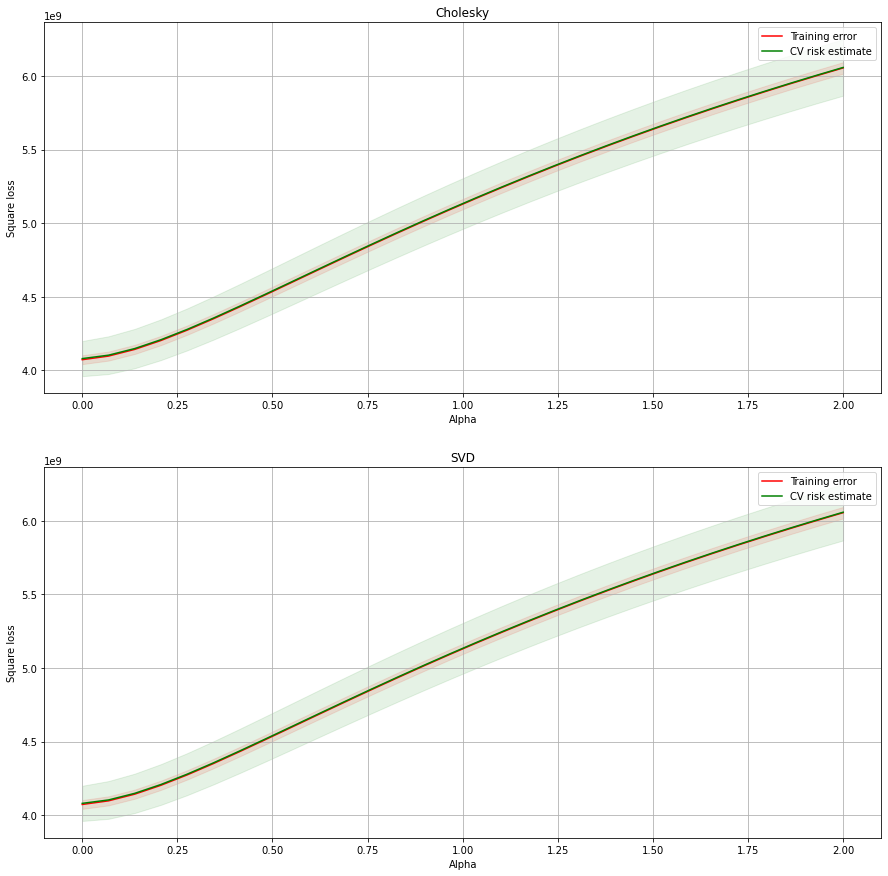

In [23]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

ax1.fill_between(alphas, train_score_mean__c - train_score_std__c, train_score_mean__c + train_score_std__c, alpha=0.1, color="r")
ax1.fill_between(alphas, val_score_mean__c - val_score_std__c, val_score_mean__c + val_score_std__c, alpha=0.1, color="g")

ax1.plot(alphas, train_score_mean__c, color="r", label="Training error")
ax1.plot(alphas, val_score_mean__c, color="g", label="CV risk estimate")


ax2.fill_between(alphas, train_score_mean__s - train_score_std__s, train_score_mean__s + train_score_std__s, alpha=0.1, color="r")
ax2.fill_between(alphas, val_score_mean__s - val_score_std__s, val_score_mean__s + val_score_std__s, alpha=0.1, color="g")

ax2.plot(alphas, train_score_mean__s, color="r", label="Training error")
ax2.plot(alphas, val_score_mean__s, color="g", label="CV risk estimate")


ax1.grid()
ax2.grid()

ax1.set_title('Cholesky')
ax2.set_title('SVD')

ax1.set_xlabel('Alpha')
ax1.set_ylabel('Square loss')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Square loss')

ax1.legend()
ax2.legend()

plt.show()

### Learning curve

Determines cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

In [24]:
min_ts = int(X.shape[0] * 0.1)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.05)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(1967, 15740, 983)


In [25]:
svd = Ridge(alpha=1e-15, solver='svd', fit_intercept=fit_intercept, normalize=normalize)

# Returns:
# -Numbers of training examples that has been used to generate the learning curve. Note that the number of ticks might be less than n_ticks because duplicate entries will be removed;
# -Scores on training sets;
# -Scores on test set.
train_size, train_score, val_score = learning_curve(svd, X, y, train_sizes=sizes, cv=5, scoring=RMS)

train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

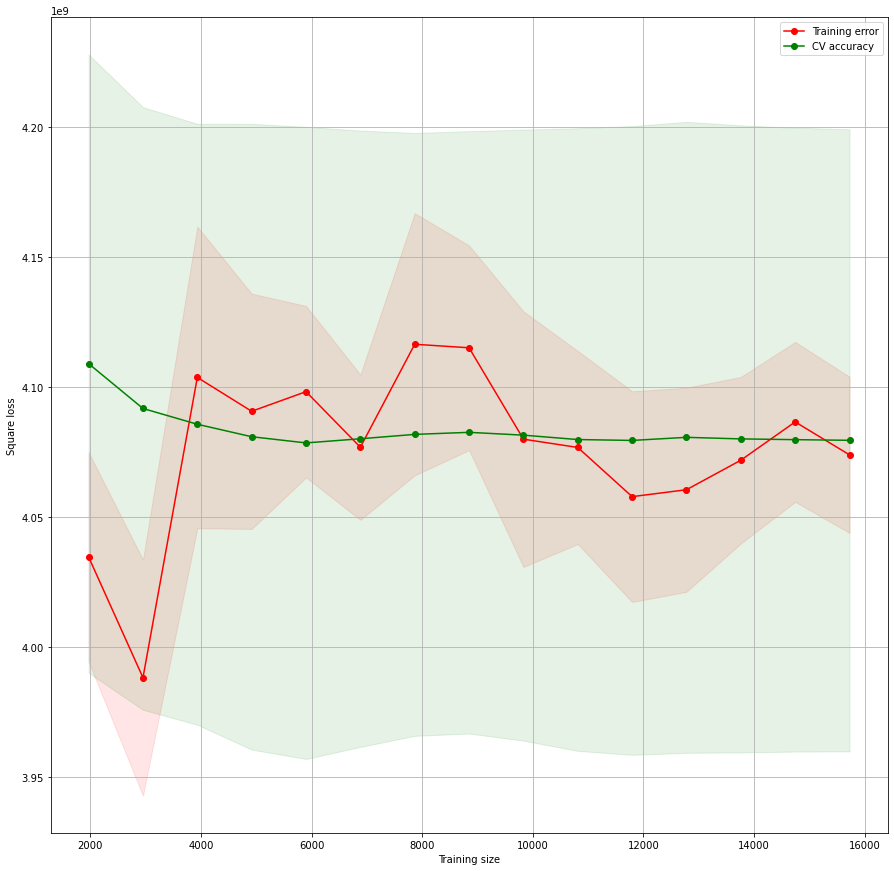

In [26]:
plt.figure(figsize=(15, 15))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="CV accuracy")

plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

## Learning algorithm
Before starting to learn the algorithm, the dataset must be splitted in subsets in order to preserve some data for the validation of the method.

### Train & Test
Train 60%, Test 40%

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=shuffleDataSet)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Standardize features
ANCORA NON USATO

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample X is calculated as: z = (X - μ) / σ²

In [28]:
if standardize == True:
    ss = StandardScaler()
    ss.fit(X=x_train[numerics_columns])
    x_train = ss.transform(X=x_train[numerics_columns])

usa (X-μ / √σ²) sul test

In [29]:
if standardize == True:
    centered_df = x_test[numerics_columns] - ss.mean_
    x_test = centered_df / (ss.var_ ** 0.5)
    x_test = x_test.to_numpy()

X train

In [30]:
pandas.DataFrame(x_train)

,longitude,housing_median_age,total_bedrooms,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
12984,-117.35,23.0,1535.0,1351.0,2.5395,1,0,0,0,0
19778,-122.21,15.0,327.0,324.0,6.0224,0,0,0,1,0
1372,-122.44,52.0,736.0,700.0,3.0766,0,0,0,1,0
19287,-117.58,7.0,1745.0,1600.0,5.3678,0,1,0,0,0
11924,-116.56,15.0,1529.0,1075.0,2.5405,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
116,-122.69,32.0,504.0,512.0,5.0000,1,0,0,0,0
8765,-122.14,34.0,231.0,211.0,5.5701,0,0,0,1,0
15733,-122.20,36.0,132.0,133.0,1.5809,0,0,0,1,0
8034,-117.94,33.0,334.0,343.0,4.2759,1,0,0,0,0


### Elaborazione per range di ɑ
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

In [31]:
print(alphas)

[1.00000000e-05 6.89751724e-02 1.37940345e-01 2.06905517e-01
 2.75870690e-01 3.44835862e-01 4.13801034e-01 4.82766207e-01
 5.51731379e-01 6.20696552e-01 6.89661724e-01 7.58626897e-01
 8.27592069e-01 8.96557241e-01 9.65522414e-01 1.03448759e+00
 1.10345276e+00 1.17241793e+00 1.24138310e+00 1.31034828e+00
 1.37931345e+00 1.44827862e+00 1.51724379e+00 1.58620897e+00
 1.65517414e+00 1.72413931e+00 1.79310448e+00 1.86206966e+00
 1.93103483e+00 2.00000000e+00]


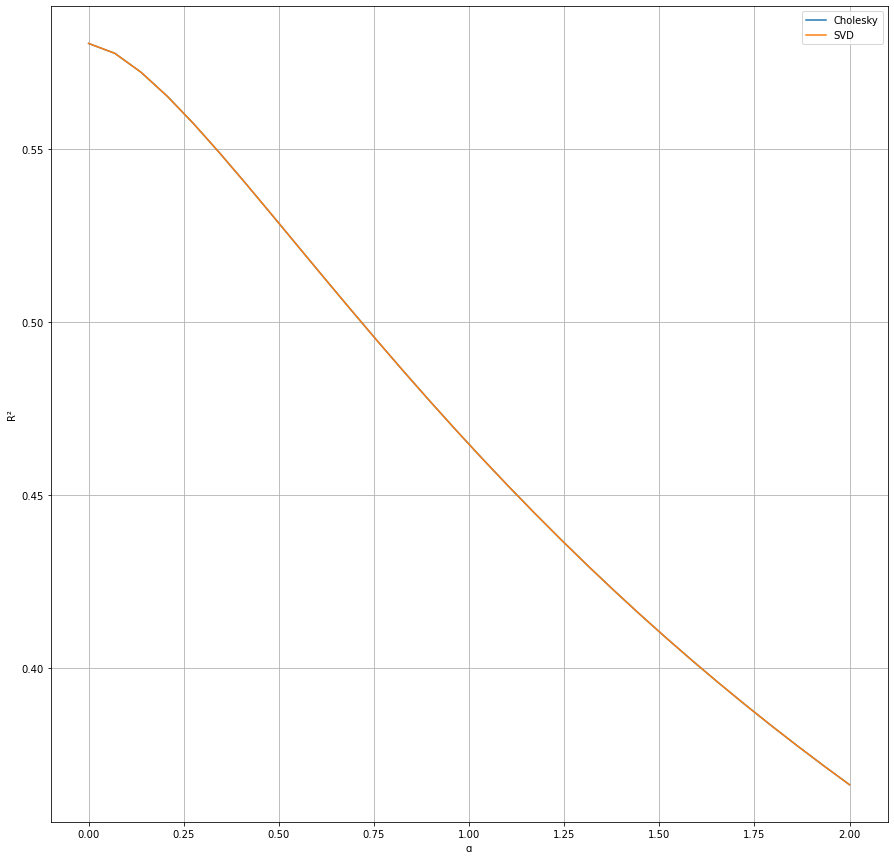

In [32]:
scores_c = []
scores_s = []

for ɑ in alphas:
    cholesky = Ridge(alpha=ɑ, solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)
    svd = Ridge(alpha=ɑ, solver='svd', fit_intercept=fit_intercept, normalize=normalize)

    cholesky.fit(x_train, y_train)
    svd.fit(x_train, y_train)

    # Return the coefficient of determination R² of the prediction.
    score_c = cholesky.score(x_test, y_test)
    score_s = svd.score(x_test, y_test)

    scores_c.append(score_c)
    scores_s.append(score_s)

plt.figure(figsize=(15, 15))

plt.plot(alphas, scores_c, label='Cholesky')
plt.plot(alphas, scores_s, label='SVD')

plt.xlabel("ɑ")
plt.ylabel("R²")

plt.legend()
plt.grid()
plt.show()

In [33]:
idx_max_c = numpy.argmax(scores_c)
idx_max_s = numpy.argmax(scores_s)

best_alpha_c = alphas[idx_max_c]
best_alpha_s = alphas[idx_max_s]

print(f'Cholesky best ɑ: {best_alpha_c}')
print(f'Cholesky best score: {scores_c[idx_max_c]}')

print(f'SVD best ɑ: {best_alpha_s}')
print(f'SVD best score: {scores_s[idx_max_s]}')

Cholesky best ɑ: 1e-05
Cholesky best score: 0.5806127468572928
SVD best ɑ: 1e-05
SVD best score: 0.5806127468572927


In [34]:
cholesky = Ridge(alpha=best_alpha_c, solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)
svd = Ridge(alpha=best_alpha_s, solver='svd', fit_intercept=fit_intercept, normalize=normalize)

cholesky.fit(x_train, y_train, best_alpha_c)
svd.fit(x_train, y_train, best_alpha_s)

y_predict_c = cholesky.predict(x_test)
y_predict_s = svd.predict(x_test)

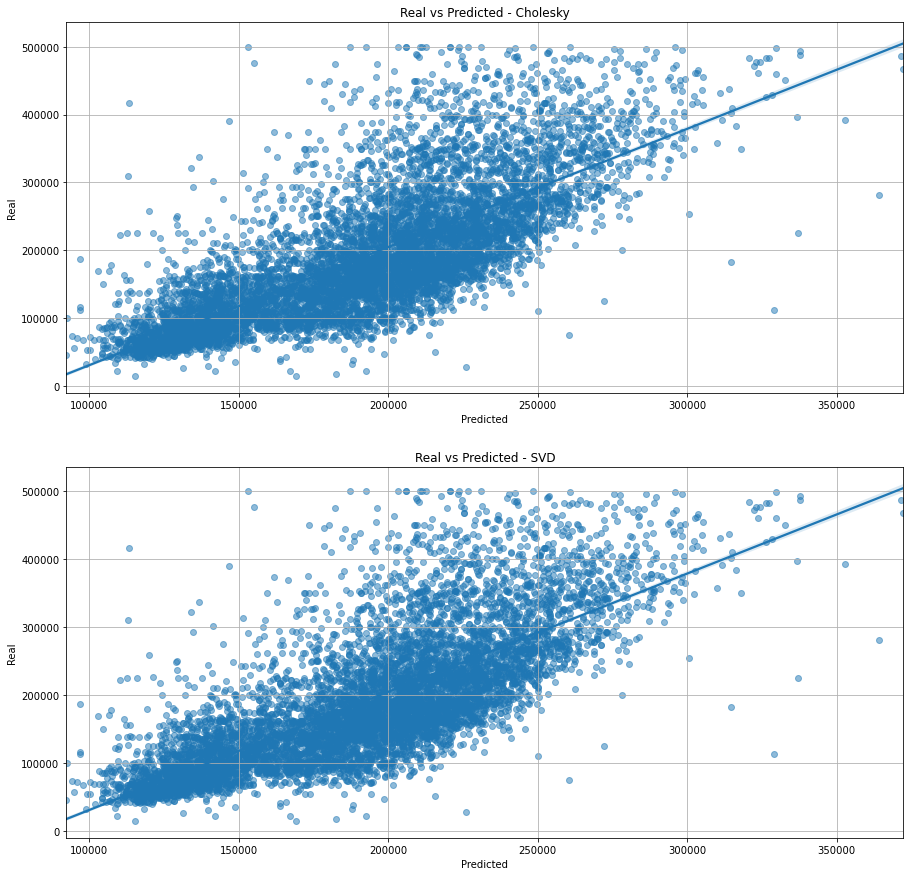

In [35]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

ax1.set_title('Real vs Predicted - Cholesky')
ax2.set_title('Real vs Predicted - SVD')

seaborn.regplot(y_predict_c, y_test, scatter_kws={'alpha':0.5}, ax=ax1)
seaborn.regplot(y_predict_s, y_test, scatter_kws={'alpha':0.5}, ax=ax2)

ax1.set_xlabel('Predicted')
ax1.set_ylabel('Real')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Real')

ax1.grid()
ax2.grid()

plt.show()

### Cross-validated risk estimate
Cross Validation is is a method that allows to perform selection and  validation of the learning algorithm. 

Set aside a portion of the data for the test set and perform multiple interations on the training data, splitted in k-folds and validate the hyperparameter to one fold per time . Then compare to the test data.

Method for comparing is the root mean squared error.

Normalize to get values normalized

Use the 5-fold cross validation

#### K-Folds cross-validator
Provides train/test indices to split data in train/test sets.

Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

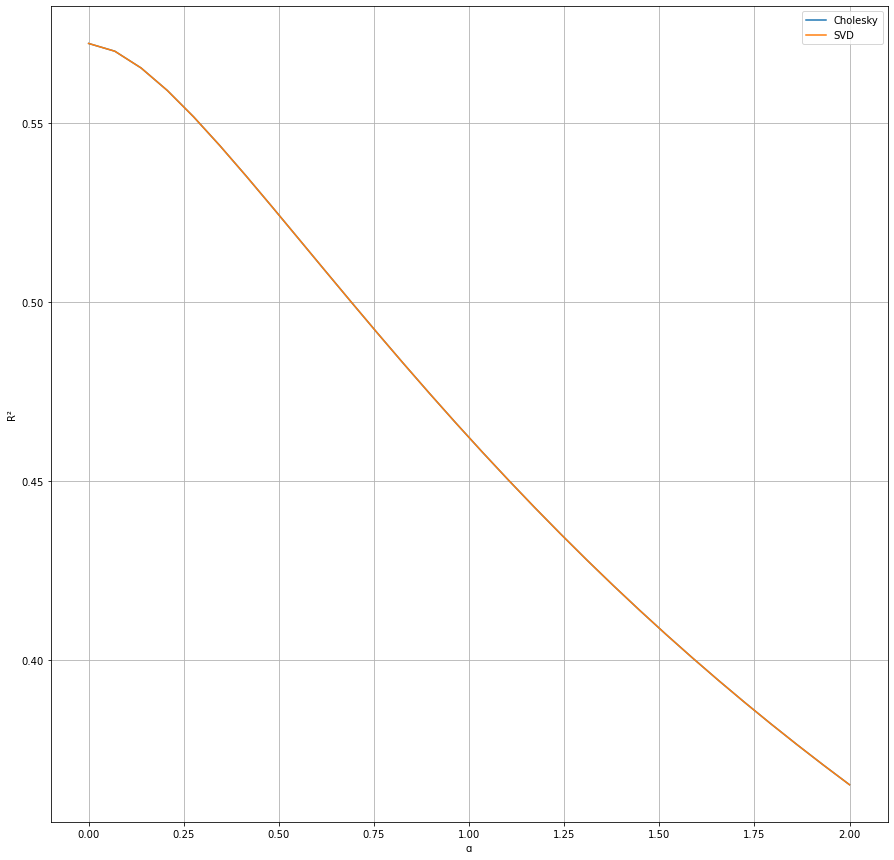

In [36]:
scores_c = []
scores_s = []

for ɑ in alphas:
    cholesky = Ridge(alpha=ɑ, solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)
    svd = Ridge(alpha=ɑ, solver='svd', fit_intercept=fit_intercept, normalize=normalize)

    score_c = cross_val_score(cholesky, X, y, cv=6).mean()
    score_s = cross_val_score(svd, X, y, cv=6).mean()

    scores_c.append(score_c)
    scores_s.append(score_s)

plt.figure(figsize=(15, 15))
plt.xlabel('ɑ')
plt.ylabel('R²')

plt.plot(alphas, scores_c, label='Cholesky')
plt.plot(alphas, scores_s, label='SVD')

plt.legend()
plt.grid()
plt.show()

In [37]:
idx_max_c = numpy.argmax(scores_c)
idx_max_s = numpy.argmax(scores_s)

if best_alpha_c == alphas[idx_max_c]:
    print('Il valore di ɑ per Cholesky è invariato!')
else:    
    best_alpha_c = alphas[idx_max_c]
    print(f'Cholesky best ɑ: {best_alpha_c}')

if best_alpha_s == alphas[idx_max_s]:
    print('Il valore di ɑ per SVD è invariato!')
else:    
    best_alpha_s = alphas[idx_max_s]
    print(f'SVD best ɑ: {best_alpha_s}')

Il valore di ɑ per Cholesky è invariato!
Il valore di ɑ per SVD è invariato!


In [38]:
if best_alpha_c != alphas[idx_max_c]:
    cholesky = Ridge(alpha=best_alpha_c, solver='cholesky', fit_intercept=fit_intercept, normalize=normalize)
    cholesky.fit(x_train, y_train, best_alpha_c)
    y_predict_c = cholesky.predict(x_test)
    score_c = cholesky.score(x_test, y_test)
    print(f'Cholesky score: {score_c}')

if best_alpha_s != alphas[idx_max_s]:
    svd = Ridge(alpha=best_alpha_s, solver='svd', fit_intercept=fit_intercept, normalize=normalize)
    svd.fit(x_train, y_train, best_alpha_s)
    y_predict_s = svd.predict(x_test)
    score_s = svd.score(x_test, y_test)
    print(f'SVD score: {score_s}')

In [39]:
if best_alpha_c != alphas[idx_max_c] or best_alpha_s != alphas[idx_max_s]:
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

    ax1.set_title('Real vs Predicted - Cholesky')
    ax2.set_title('Real vs Predicted - SVD')

    seaborn.regplot(y_predict_c, y_test, scatter_kws={'alpha':0.5}, ax=ax1)
    seaborn.regplot(y_predict_s, y_test, scatter_kws={'alpha':0.5}, ax=ax2)

    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Real')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Real')

    ax1.grid()
    ax2.grid()

    plt.show()